# List Contents of Directory

In [ ]:
dbutils.fs.ls("/FileStore/tables")

Out[52]: [FileInfo(path='dbfs:/FileStore/tables/0ed442ca38ad_user_table/', name='0ed442ca38ad_user_table/', size=0, modificationTime=1702749927906),
 FileInfo(path='dbfs:/FileStore/tables/authentication_credentials.csv', name='authentication_credentials.csv', size=202, modificationTime=1687110999000),
 FileInfo(path='dbfs:/FileStore/tables/geo_dirty.csv/', name='geo_dirty.csv/', size=0, modificationTime=1702749927906),
 FileInfo(path='dbfs:/FileStore/tables/pin_dirty.csv/', name='pin_dirty.csv/', size=0, modificationTime=1702749927906),
 FileInfo(path='dbfs:/FileStore/tables/single_json_file.json', name='single_json_file.json', size=293, modificationTime=1701857903000),
 FileInfo(path='dbfs:/FileStore/tables/user_dirty.csv/', name='user_dirty.csv/', size=0, modificationTime=1702749927906)]

# Read AWS Credentials from CSV File

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import urllib

"""
Read AWS authentication credentials from a CSV file and extract the access key and secret key.

Parameters:
- spark (SparkSession): The Spark session.
- file_path (str): The path to the CSV file containing authentication credentials.

Returns:
- str: AWS access key.
- str: AWS secret key.
- str: URL-encoded AWS secret key.
"""
# Specify file type to be csv
file_type = "csv"
# Indicates file has first row as the header
first_row_is_header = "true"
# Indicates file has comma as the delimeter
delimiter = ","
# Read the CSV file to spark dataframe
aws_keys_df = spark.read.format(file_type)\
    .option("header", first_row_is_header)\
    .option("sep", delimiter)\
    .load("dbfs:/FileStore/tables/authentication_credentials.csv")
     

# Get the AWS access key and secret key from the spark dataframe
ACCESS_KEY = aws_keys_df.where(col('User name')=='databricks-user').select('Access key ID').collect()[0]['Access key ID']
SECRET_KEY = aws_keys_df.where(col('User name')=='databricks-user').select('Secret access key').collect()[0]['Secret access key']
# Encode the secrete key
ENCODED_SECRET_KEY = urllib.parse.quote(string=SECRET_KEY, safe="")

(3) Spark Jobs
Job 979229 View(Stages: 1/1)
Job 979242 View(Stages: 1/1)
Job 979253 View(Stages: 1/1)
aws_keys_df:pyspark.sql.dataframe.DataFrame
User name:string
Password:string
Access key ID:string
Secret access key:string
Console login link:string

# Kinesis Stream Functions
## Retrive Kinesius steam

In [ ]:
"""
Retrieves a Kinesis stream as a DataFrame using spark.readStream.

Parameters:
- stream_name (str): The name of the Kinesis stream.

Returns:
- DataFrame: The Kinesis stream as a DataFrame.
"""
def get_stream(stream_name: str):
    '''Uses spark.readStream to retrieve Kinesis stream and returns stream as dataframe'''
    dataframe = spark \
    .readStream \
    .format('kinesis') \
    .option('streamName', stream_name) \
    .option('initialPosition','earliest') \
    .option('region','us-east-1') \
    .option('awsAccessKey', ACCESS_KEY) \
    .option('awsSecretKey', SECRET_KEY) \
    .load()
    return dataframe

## Deserialize data from Kinesis stream

In [ ]:
"""
Deserializes data from a Kinesis stream DataFrame using the provided schema.

Parameters:
- stream (DataFrame): The Kinesis stream DataFrame.
- schema (StructType): The schema to be used for deserialization.

Returns:
- DataFrame: The deserialized data as a DataFrame.
"""
def deserialize_stream(stream, schema):
    '''Takes stream dataframe and schema, deserializes data from stream and returns data as dataframe'''
    dataframe = stream \
    .selectExpr("CAST(data as STRING)") \
    .withColumn("data", from_json(col("data"), schema)) \
    .select(col("data.*"))
    return dataframe

## DataFrame Transformation Functions

In [ ]:
"""
Converts matched values in a column of the DataFrame to null based on the specified expression.

Parameters:
- dataframe (DataFrame): The DataFrame.
- column (str): The name of the column to process.
- value_to_replace (str): The value to be replaced with null.

Returns:
- DataFrame: The DataFrame with null values in the specified column.
"""
def add_nulls_to_dataframe_column(dataframe, column, value_to_replace):
    '''Converts matched values in column of dataframe to null based on expression'''
    dataframe = dataframe.withColumn(column, when(col(column).like(value_to_replace), None).otherwise(col(column)))
    return dataframe

"""
Writes a streaming DataFrame to a Delta table.

Parameters:
- dataframe (DataFrame): The streaming DataFrame to be written.
- name (str): A name string used in options and the table name.

Returns:
- Data in the Delta table.
"""
def write_stream_df_to_table(dataframe, name: str):
    '''Takes dataframe and name string and writes dataframe to delta table using name in options and table name'''
    dataframe.writeStream \
    .format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", f"/tmp/kinesis/0abb070c336b_{name}_table_checkpoints/") \
    .table(f"0abb070c336b_{name}_table")

Command took 9.24 seconds -- by mariuszgrocki@duck.com at 17/12/2023, 11:21:47 on Pinterest Cluster

## Define Schema for DataFrames

In [ ]:
"""
Define the schema for the 'pin' DataFrame.

Returns:
pyspark.sql.types.StructType: The schema for the 'pin' DataFrame.
"""
pin_schema = StructType([
    StructField("index", IntegerType()),
    StructField("unique_id", StringType()),
    StructField("title", StringType()),
    StructField("description", StringType()),
    StructField("poster_name", StringType()),
    StructField("follower_count", StringType()),
    StructField("tag_list", StringType()),
    StructField("is_image_or_video", StringType()),
    StructField("image_src", StringType()),
    StructField("downloaded", IntegerType()),
    StructField("save_location", StringType()),
    StructField("category", StringType())
])

"""
Define the schema for the 'geo' DataFrame.

Returns:
pyspark.sql.types.StructType: The schema for the 'geo' DataFrame.
"""
geo_schema = StructType([
    StructField("ind", IntegerType()),
    StructField("timestamp", TimestampType()),
    StructField("latitude", FloatType()),
    StructField("longitude", FloatType()),
    StructField("country", StringType())
])

"""
Define the schema for the 'user' DataFrame.

Returns:
pyspark.sql.types.StructType: The schema for the 'user' DataFrame.
"""
user_schema = StructType([
    StructField("ind", IntegerType()),
    StructField("first_name", StringType()),
    StructField("last_name", StringType()),
    StructField("age", StringType()),
    StructField("date_joined", TimestampType())
])

## Retrieve Kinesis Data Streams

In [ ]:
"""
Retrieves the Kinesis data stream for Pinterest posts, geolocation data, and user data.

Returns:
KinesisStream: The Kinesis data streams.
"""
pin_stream = get_stream('streaming-0abb070c336b-pin')
geo_stream = get_stream('streaming-0abb070c336b-geo')
user_stream = get_stream('streaming-0abb070c336b-user')

pin_stream:pyspark.sql.dataframe.DataFrame
partitionKey:string
data:binary
stream:string
shardId:string
sequenceNumber:string
approximateArrivalTimestamp:timestamp
geo_stream:pyspark.sql.dataframe.DataFrame
partitionKey:string
data:binary
stream:string
shardId:string
sequenceNumber:string
approximateArrivalTimestamp:timestamp
user_stream:pyspark.sql.dataframe.DataFrame
partitionKey:string
data:binary
stream:string
shardId:string
sequenceNumber:string
approximateArrivalTimestamp:timestamp

## Deserialize Kinesis Streams

In [ ]:
"""
Deserialiselize a streaming DataFrame from a specified stream using the provided schema.

Parameters:
- stream (str): The name of the stream to deserialize.
- schema (StructType): The schema to apply to the deserialized DataFrame.

Returns:
- DataFrame: The deserialised DataFrame.
"""
df_pin = deserialize_stream(pin_stream, pin_schema)
df_geo = deserialize_stream(geo_stream, geo_schema)
df_user = deserialize_stream(user_stream, user_schema)

df_pin:pyspark.sql.dataframe.DataFrame
index:integer
unique_id:string
title:string
description:string
poster_name:string
follower_count:string
tag_list:string
is_image_or_video:string
image_src:string
downloaded:integer
save_location:string
category:string
df_geo:pyspark.sql.dataframe.DataFrame
ind:integer
timestamp:timestamp
latitude:float
longitude:float
country:string
df_user:pyspark.sql.dataframe.DataFrame
ind:integer
first_name:string
last_name:string
age:string
date_joined:timestamp

# DataFrame Transformations

In [ ]:
"""
The code performs a series of data cleaning and transformation operations on the DataFrame df_pin.

1. Replace empty entries and entries with no relevant data in specific columns with None.
   - Columns and values for replacement are defined in the dictionary columns_and_values_for_null.

2. Perform necessary transformations on the 'follower_count' column to ensure every entry is a number.
   - Replace 'k' with '000' and 'M' with '000000'.

3. Cast selected numeric columns to the correct data type ('double').
   - Numeric columns are specified in the list numeric_columns.

4. Modify the 'save_location' column to include only the saved location path.
   - Remove the prefix 'Local save in '.

5. Rename the 'index' column to 'ind'.

6. Reorder the DataFrame columns to the desired sequence specified in the new_order list.

7. Display the changes using df_pin.show().

Note: The add_nulls_to_dataframe_column function is assumed to be defined elsewhere in the codebase.
"""

# Columns and values to change to nulla
columns_and_values_for_null = {
    "description": "No description available%",
    "follower_count": "User Info Error",
    "image_src": "Image src error.",
    "poster_name": "User Info Error",
    "tag_list": "N,o, ,T,a,g,s, ,A,v,a,i,l,a,b,l,e",
    "title": "No Title Data Available"
}
# Loop through dictionary, calling function with dictionary values as arguments
for key, value in columns_and_values_for_null.items():
    df_pin = add_nulls_to_dataframe_column(df_pin, key, value)
# Perform the necessary transformations on the follower_count to ensure every entry is a number
df_pin = df_pin.withColumn("follower_count", regexp_replace("follower_count", "k", "000"))
df_pin = df_pin.withColumn("follower_count", regexp_replace("follower_count", "M", "000000"))
# cast follower_count column to integer type
df_pin = df_pin.withColumn("follower_count", col("follower_count").cast('int'))
# convert save_location column to include only the save location path
df_pin = df_pin.withColumn("save_location", regexp_replace("save_location", "Local save in ", ""))
# rename the index column to ind
df_pin = df_pin.withColumnRenamed("index", "ind")
# reorder columns
new_pin_column_order = [
    "ind",
    "unique_id",
    "title",
    "description",
    "follower_count",
    "poster_name",
    "tag_list",
    "is_image_or_video",
    "image_src",
    "save_location",
    "category"
]
df_pin = df_pin.select(new_pin_column_order)

df_pin:pyspark.sql.dataframe.DataFrame
ind:integer
unique_id:string
title:string
description:string
follower_count:integer
poster_name:string
tag_list:string
is_image_or_video:string
image_src:string
save_location:string
category:string


In [ ]:
"""
Transforms the user DataFrame with the following steps:

1. Create a new column for the full name by concatenating 'first_name' and 'last_name'.
2. Drop the 'first_name' and 'last_name' columns.
3. Convert the 'date_joined' column to timestamp data type.
4. Define the desired new column order.
5. Reorder the DataFrame columns to enforce the new order.
6. Display the updated DataFrame.
7. Print the schema changes.

Parameters:
- df_user (DataFrame): The original user DataFrame.

Returns:
- df_user (DataFrame): The transformed user DataFrame.
"""

# import types
from pyspark.sql.types import ArrayType, DoubleType
# define function for returning list containing two values
def combine_lat_and_long(latitude, longitude):
    return [latitude, longitude]
# define new user-defined function
new_func = udf(combine_lat_and_long, ArrayType(DoubleType()))
# apply new udf to combine latitude and longitude columns
df_geo = df_geo.withColumn("coordinates", new_func("latitude", "longitude"))
# drop the latitude and longitude columns
cols_to_drop = ("latitude", "longitude")
df_geo = df_geo.drop(*cols_to_drop)
# convert timestamp column from type string to type timestamp
df_geo = df_geo.withColumn("timestamp", to_timestamp("timestamp"))
# change column order
new_geo_column_order = [
    "ind",
    "country",
    "coordinates",
    "timestamp",
]
df_geo = df_geo.select(new_geo_column_order)

df_geo:pyspark.sql.dataframe.DataFrame
ind:integer
country:string
coordinates:array
element:double
timestamp:timestamp

In [ ]:
"""
Transforms the user DataFrame with the following steps:

1. Create a new column for the full name by concatenating 'first_name' and 'last_name'.
2. Drop the 'first_name' and 'last_name' columns.
3. Convert the 'date_joined' column to timestamp data type.
4. Define the desired new column order.
5. Reorder the DataFrame columns to enforce the new order.
6. Display the updated DataFrame.
7. Print the schema changes.

Parameters:
- df_user (DataFrame): The original user DataFrame.

Returns:
- df_user (DataFrame): The transformed user DataFrame.
"""
# create new column for full name
df_user = df_user.withColumn("user_name", concat_ws(" ", "first_name", "last_name"))
# drop the first_name and last_name columns
cols_to_drop = ("first_name", "last_name")
df_user = df_user.drop(*cols_to_drop)
# convert date_joined column from type string to type timestamp
df_user = df_user.withColumn("date_joined", to_timestamp("date_joined"))
# change column order
new_user_column_order = [
    "ind",
    "user_name",
    "age",
    "date_joined",
]
df_user = df_user.select(new_user_column_order)

df_user:pyspark.sql.dataframe.DataFrame
ind:integer
user_name:string
age:string
date_joined:timestamp

# Process and Display DataFrames

In [ ]:
"""
Process dataframes and display them.

Parameters:
- df_pin (DataFrame): DataFrame for Pinterest data.
- df_geo (DataFrame): DataFrame for geolocation data.
- df_user (DataFrame): DataFrame for user data.

Returns:
None
"""
display(df_pin)
display(df_geo)
display(df_user)


display_query_572(id: f73688fa-782a-4f67-9ca2-ff55a3af7bc9)
Last updated: 10 seconds ago
display_query_571(id: 1f3344a0-4b4f-485a-9ea1-c2da124ce630)
Last updated: 5 seconds ago
display_query_570(id: 062cb61b-d1d1-43ed-95a0-d300d75c76de)
Last updated: 5 seconds ago

In [ ]:
"""
Write the streaming DataFrame to a Delta table.

Parameters:
- dataframe (pyspark.sql.DataFrame): The streaming DataFrame to be written to the Delta table.
- table_name (str): The name of the Delta table to be created.

Returns:
None
"""

write_stream_df_to_table(df_pin, "pin")
write_stream_df_to_table(df_geo, "geo")
write_stream_df_to_table(df_user, "user")

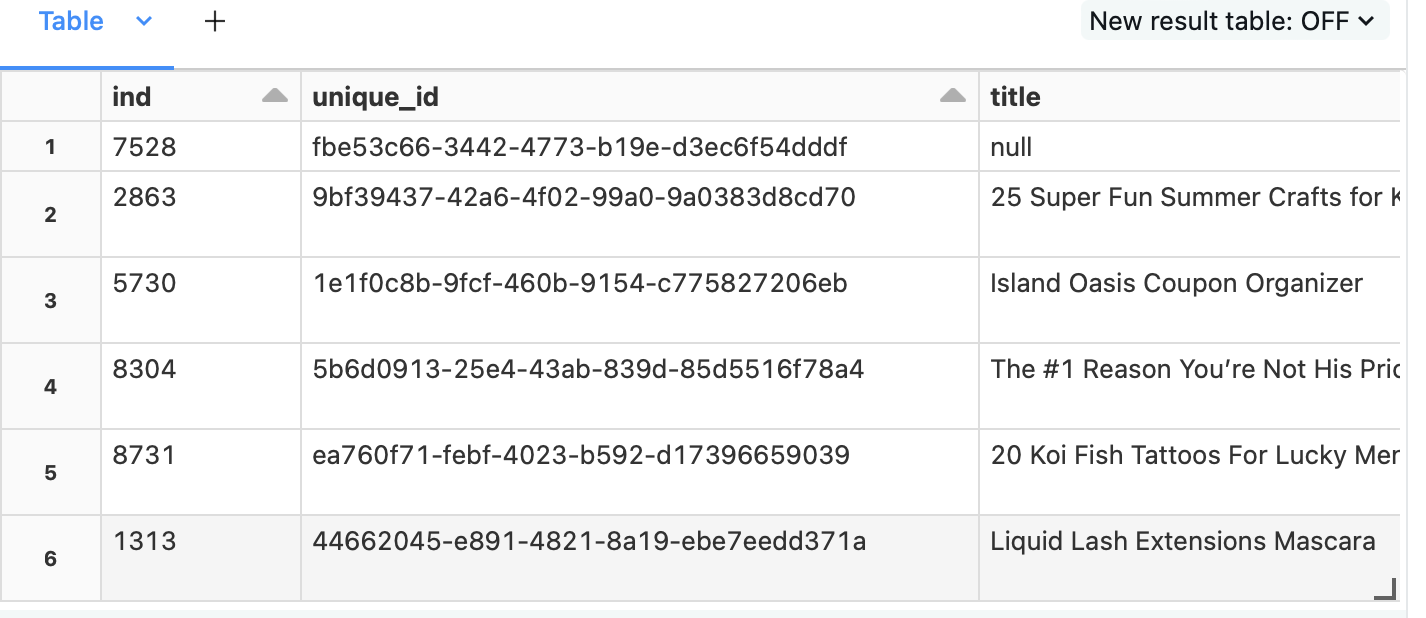

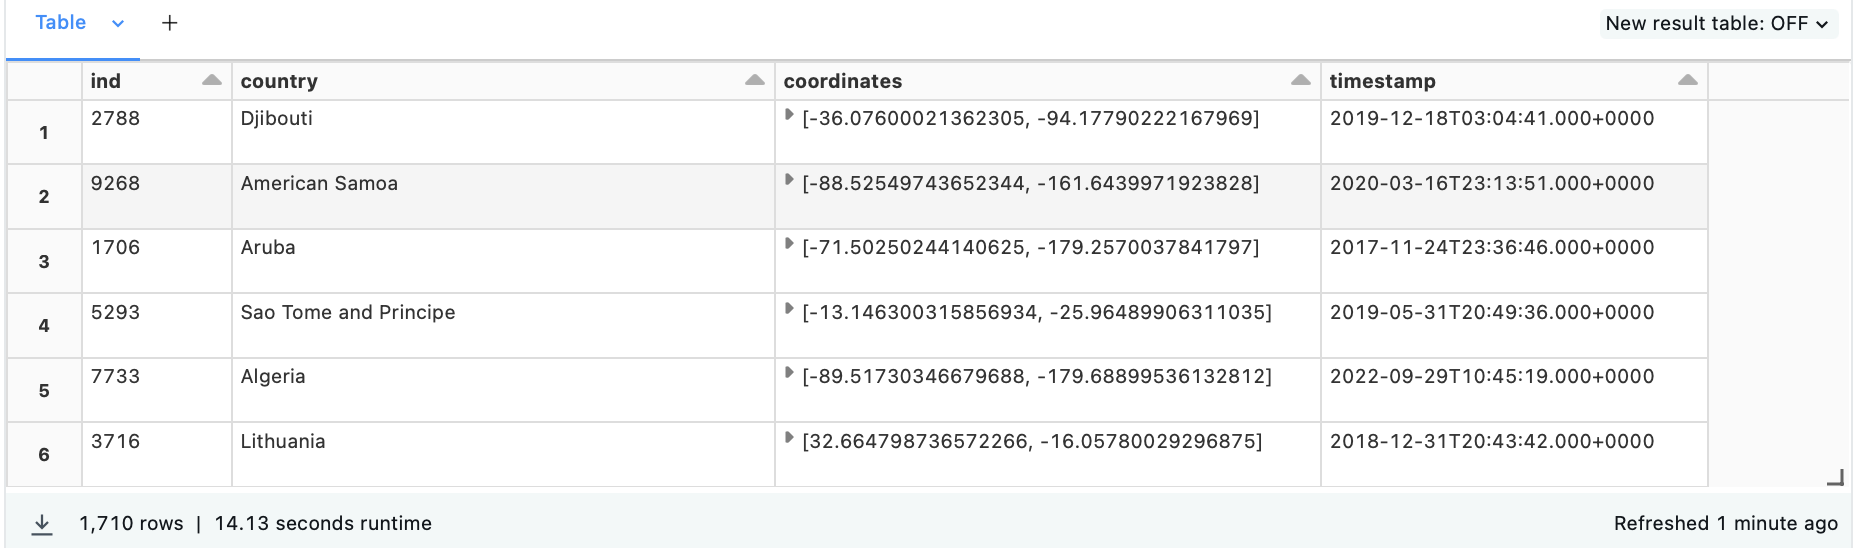

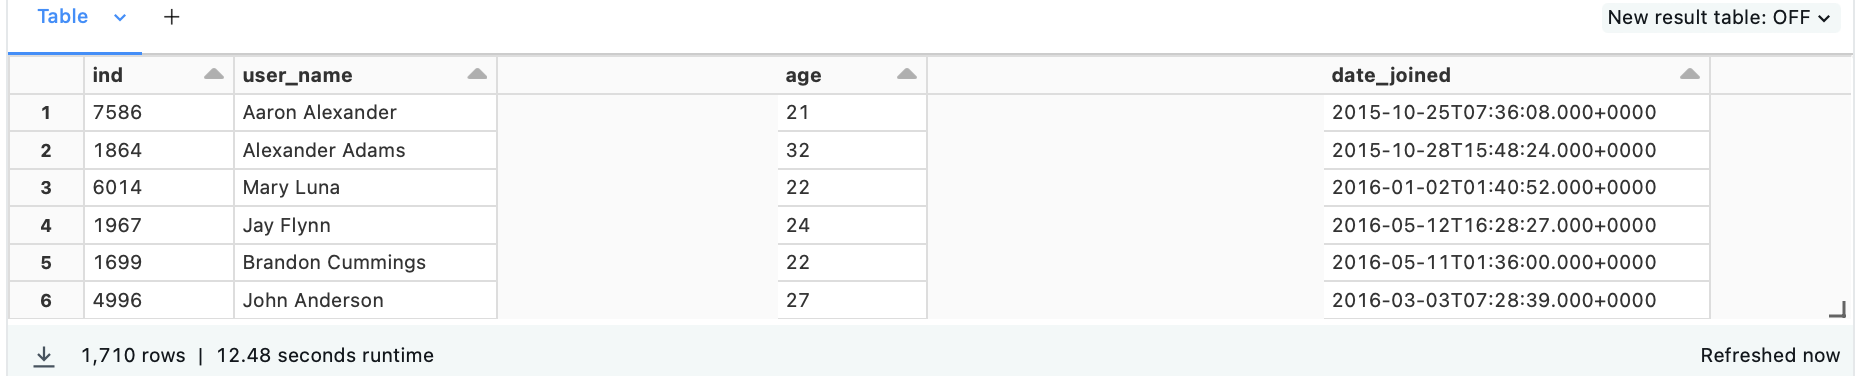